In [68]:
# import os
# import csv
# import time
# import itertools
# import networkx as nx
# import osmnx as ox
# import numpy as np
# import random
# from tqdm import tqdm
# from shapely.geometry import LineString

# # Set fixed random seeds for reproducibility
# random.seed(42)
# np.random.seed(42)

# ox.settings.use_cache = True
# ox.settings.log_console = False

# # Grid Search Configuration
# PARAM_GRID = {
#     'num_ants': [5, 10],
#     'num_iterations': [50, 100],
#     'alpha': [1.0, 1.5],
#     'beta': [2.0, 3.0],
#     'evaporation_rate': [0.1, 0.2],
#     'max_route_distance': [10000, 15000],
#     'coverage_factor': [5000, 7500],
#     'num_precomputed_solutions': [3, 5]
# }

# class ACOConfig:
#     def __init__(self, **kwargs):
#         self.num_ants = kwargs.get('num_ants', 5)
#         self.num_iterations = kwargs.get('num_iterations', 50)
#         self.alpha = kwargs.get('alpha', 1.0)
#         self.beta = kwargs.get('beta', 2.0)
#         self.evaporation_rate = kwargs.get('evaporation_rate', 0.1)
#         self.Q = 100
#         self.max_route_distance = kwargs.get('max_route_distance', 15000)
#         self.penalty_factor = 10000
#         self.coverage_factor = kwargs.get('coverage_factor', 5000)
#         self.max_route_steps = 20
#         self.num_precomputed_solutions = kwargs.get('num_precomputed_solutions', 3)

# def load_road_network(place="Coimbatore, India", cache_dir="road_cache"):
#     os.makedirs(cache_dir, exist_ok=True)
#     safe_place = place.replace(" ", "_").replace(",", "")
#     cache_file = os.path.join(cache_dir, f"{safe_place}_network.graphml")
    
#     if os.path.exists(cache_file):
#         return ox.load_graphml(cache_file)
    
#     G = ox.graph_from_place(place, network_type="drive", simplify=True)
#     ox.save_graphml(G, cache_file)
#     return G

# def get_police_station_nodes(G, place="Coimbatore, India"):
#     try:
#         gdf_police = ox.features_from_place(place, tags={"amenity": "police"})
#         return list(set([ox.distance.nearest_nodes(G, geom.centroid.x, geom.centroid.y) 
#                        for geom in gdf_police.geometry if not geom.is_empty]))
#     except Exception:
#         return []

# def build_rrt_route(G, max_route_distance=15000, max_route_steps=20):
#     nodes = list(G.nodes())
#     if not nodes:
#         return []
    
#     current = np.random.choice(nodes)
#     route = [current]
#     dist_so_far = 0.0
#     edge_lengths = {(u, v): data['length'] for u, v, data in G.edges(data=True)}
    
#     for _ in range(max_route_steps):
#         rand_node = np.random.choice(nodes)
#         if rand_node == current:
#             continue
        
#         try:
#             path = nx.shortest_path(G, current, rand_node, weight='length')
#         except nx.NetworkXNoPath:
#             continue
        
#         path_length = sum(edge_lengths.get((u, v), edge_lengths.get((v, u), 0)) 
#                          for u, v in zip(path[:-1], path[1:]))
        
#         if dist_so_far + path_length > max_route_distance:
#             break
            
#         route.extend(path[1:])
#         dist_so_far += path_length
#         current = rand_node
    
#     return route

# def build_rrt_solution(G, num_vehicles, max_route_distance=15000, max_route_steps=20):
#     return [build_rrt_route(G, max_route_distance, max_route_steps) 
#             for _ in range(num_vehicles)]

# class RRTACOOptimizer:
#     def __init__(self, G, config, station_nodes=None):
#         self.G = G
#         self.config = config
#         self.station_nodes = station_nodes or []
#         self.edge_lengths = {(u, v): data['length'] for u, v, data in G.edges(data=True)}
#         self.pheromone = {edge: 1.0 for edge in self.edge_lengths.keys()}
#         self.best_solution = None
#         self.best_fitness = -np.inf

#     def build_ant_route(self):
#         nodes = list(self.G.nodes())
#         if not nodes:
#             return []
        
#         current = self.station_nodes.pop(0) if self.station_nodes else np.random.choice(nodes)
#         route = [current]
#         dist_so_far = 0.0
        
#         for _ in range(self.config.max_route_steps):
#             neighbors = list(self.G.neighbors(current))
#             if not neighbors:
#                 break
                
#             weights = []
#             for neighbor in neighbors:
#                 pheromone = self.pheromone.get((current, neighbor), 1e-6)
#                 length = self.edge_lengths.get((current, neighbor), 
#                       self.edge_lengths.get((neighbor, current), 1))
#                 weights.append((pheromone ** self.config.alpha) * ((1/length) ** self.config.beta))
            
#             total = sum(weights)
#             if total == 0:
#                 break
                
#             probs = [w/total for w in weights]
#             next_node = np.random.choice(neighbors, p=probs)
            
#             try:
#                 path = nx.shortest_path(self.G, current, next_node, weight='length')
#             except nx.NetworkXNoPath:
#                 continue
            
#             path_length = sum(self.edge_lengths.get((u, v), self.edge_lengths.get((v, u), 0))
#                           for u, v in zip(path[:-1], path[1:]))
            
#             if dist_so_far + path_length > self.config.max_route_distance:
#                 break
                
#             route.extend(path[1:])
#             dist_so_far += path_length
#             current = next_node
        
#         return route

#     def fitness(self, solution):
#         edge_counts = {}
#         covered = set()
        
#         for route in solution:
#             for u, v in zip(route[:-1], route[1:]):
#                 edge = (u, v) if (u, v) in self.edge_lengths else (v, u)
#                 edge_counts[edge] = edge_counts.get(edge, 0) + 1
#                 covered.add(edge)
        
#         coverage = sum(self.edge_lengths[edge] for edge in covered) * self.config.coverage_factor
#         penalty = sum((count - 3) * self.edge_lengths[edge] * self.config.penalty_factor
#                      for edge, count in edge_counts.items() if count > 3)
        
#         return coverage - penalty

#     def run(self, precomputed_solutions):
#         self._seed_pheromones(precomputed_solutions)
        
#         for _ in range(self.config.num_iterations):
#             solutions = [self.build_ant_route() for _ in range(self.config.num_ants)]
#             fitness = self.fitness(solutions)
            
#             if fitness > self.best_fitness:
#                 self.best_fitness = fitness
#                 self.best_solution = solutions
                
#             self._evaporate()
#             self._deposit(solutions, fitness)
        
#         return self.best_solution, self.best_fitness

#     def _seed_pheromones(self, solutions):
#         for solution in solutions:
#             for route in solution:
#                 for u, v in zip(route[:-1], route[1:]):
#                     edge = (u, v) if (u, v) in self.pheromone else (v, u)
#                     if edge in self.pheromone:
#                         self.pheromone[edge] += 2.0

#     def _evaporate(self):
#         for edge in self.pheromone:
#             self.pheromone[edge] *= (1 - self.config.evaporation_rate)

#     def _deposit(self, solution, fitness):
#         deposit = (self.config.Q * fitness) / 1000
#         for route in solution:
#             for u, v in zip(route[:-1], route[1:]):
#                 edge = (u, v) if (u, v) in self.pheromone else (v, u)
#                 if edge in self.pheromone:
#                     self.pheromone[edge] += deposit

# def grid_search():
#     G = load_road_network()
#     station_nodes = get_police_station_nodes(G)
#     results = []
    
#     param_combinations = [dict(zip(PARAM_GRID.keys(), vals)) 
#                         for vals in itertools.product(*PARAM_GRID.values())]
    
#     print(f"Starting grid search with {len(param_combinations)} combinations")
    
#     for idx, params in tqdm(enumerate(param_combinations, 1)):
#         print(f"\nCombination {idx}/{len(param_combinations)}")
#         print("Parameters:", params)
        
#         try:
#             config = ACOConfig(**params)
#             precomputed = [build_rrt_solution(G, config.num_ants, 
#                              config.max_route_distance, config.max_route_steps)
#                            for _ in range(config.num_precomputed_solutions)]
            
#             start_time = time.time()
#             optimizer = RRTACOOptimizer(G, config, station_nodes.copy())
#             _, fitness = optimizer.run(precomputed)
#             runtime = time.time() - start_time
            
#             results.append({
#                 'parameters': params,
#                 'fitness': fitness,
#                 'runtime': runtime
#             })
            
#             print(f"Fitness: {fitness:.2f} | Time: {runtime:.2f}s")
            
#         except Exception as e:
#             print(f"Error: {str(e)}")
#             continue
    
#     results.sort(key=lambda x: x['fitness'], reverse=True)
    
#     with open('grid_search_results.csv', 'w', newline='') as f:
#         writer = csv.DictWriter(f, fieldnames=['parameters', 'fitness', 'runtime'])
#         writer.writeheader()
#         for result in results[:10]:
#             writer.writerow(result)
    
#     print("\nTop 10 results saved to grid_search_results.csv")

# if __name__ == "__main__":
#     grid_search()



# Results

In [69]:
import os
import random
import networkx as nx
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt
import time
from shapely.geometry import LineString
from itertools import product
import copy
import pandas as pd
from tqdm.notebook import tqdm


In [70]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# Register tqdm with pandas
tqdm.pandas(desc="Processing")

# Create a sample DataFrame
df = pd.DataFrame(np.random.randint(0, 100, (100, 6)))

# Apply a function with progress bar
df.progress_apply(lambda x: x**2, axis=1)


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

0     1     2     3     4     5
0   2704   676  2809   900  2304     4
1    900  8281  2304  5329  8464  2401
2     49  9604  1089  9216  6561  1156
3   6400  5041  6724    81  3721  1296
4    576  5929  8836  3364  2209     9
..   ...   ...   ...   ...   ...   ...
95   729   169     4  6724  4096  7921
96  1089    25   256  4624   400   400
97   484   144  2209  2209  2401    64
98     0   289  2704  6400  5625  5929
99  2809   961   100  2304   169  1936

[100 rows x 6 columns]

In [71]:
def load_road_network(place="Coimbatore, India", cache_dir="road_cache"):
    os.makedirs(cache_dir, exist_ok=True)
    safe_place = place.replace(" ", "_").replace(",", "")
    cache_file = os.path.join(cache_dir, f"{safe_place}_network.graphml")

    major_road_network = r"C:\Users\DELL\Documents\Amrita\4th year\ArcGis\major_road_cache\\road_cache\Coimbatore_India_highways_primary.graphml"

    if os.path.exists(major_road_network):
        print(f"Loading cached road network from {major_road_network}")
        G = ox.load_graphml(major_road_network)
    elif os.path.exists(cache_file):
        print(f"Loading cached road network from {cache_file}")
        G = ox.load_graphml(cache_file)
    else:
        print(f"Downloading road network for {place}")
        G = ox.graph_from_place(place, network_type="drive", simplify=True)
        ox.save_graphml(G, cache_file)

    return G
def get_police_station_nodes(G, place="Coimbatore, India"):
    try:
        gdf_police = ox.features_from_place(place, tags={"amenity": "police"})
    except Exception as e:
        print(f"Could not fetch police stations: {e}")
        return []

    if gdf_police.empty:
        print("No police stations found with the given tag. Falling back to random start nodes.")
        return []

    station_nodes = []
    for idx, row in gdf_police.iterrows():
        geom = row.geometry
        if geom is None:
            continue
        point = geom.centroid if geom.geom_type != 'Point' else geom
        node_id = ox.distance.nearest_nodes(G, point.x, point.y)
        station_nodes.append(node_id)
    return list(set(station_nodes))
def get_police_station_nodes(G, place="Coimbatore, India"):
    try:
        gdf_police = ox.features_from_place(place, tags={"amenity": "police"})
    except Exception as e:
        print(f"Could not fetch police stations: {e}")
        return []

    if gdf_police.empty:
        print("No police stations found with the given tag. Falling back to random start nodes.")
        return []

    station_nodes = []
    for idx, row in gdf_police.iterrows():
        geom = row.geometry
        if geom is None:
            continue
        point = geom.centroid if geom.geom_type != 'Point' else geom
        node_id = ox.distance.nearest_nodes(G, point.x, point.y)
        station_nodes.append(node_id)
    return list(set(station_nodes))


In [72]:
class PSOConfig:
    def __init__(self):
        self.num_vehicles = 5
        self.swarm_size = 20
        self.num_iterations = 50
        self.w = 0.5
        self.c1 = 1.5
        self.c2 = 1.5
        self.coverage_factor = 5000
        self.overlap_penalty_factor = 10000
        self.max_route_distance = 15000
        self.mutation_rate = 0.2

class PSORouteOptimizer:
    def __init__(self, G, config, start_nodes=None):
        self.G = G
        self.config = config
        self.start_nodes = start_nodes
        self.adjacency_cache = {}
        self.edge_length_cache = {}

        for node in self.G.nodes():
            self.adjacency_cache[node] = list(self.G.successors(node))

        for u, v, data in self.G.edges(data=True):
            length = data.get('length', 0)
            self.edge_length_cache[(u, v)] = length

        self.all_edges = set(self.edge_length_cache.keys())
        self.swarm = []
        self.personal_best = []
        self.personal_best_fitness = []
        self.global_best = None
        self.global_best_fitness = -float('inf')

    def build_random_route(self):
        nodes_list = list(self.G.nodes())
        if not nodes_list:
            return []
        current = random.choice(self.start_nodes) if self.start_nodes else random.choice(nodes_list)
        route = [current]
        dist_so_far = 0.0

        while True:
            neighbors = self.adjacency_cache[current]
            if not neighbors:
                break
            next_node = random.choice(neighbors)
            edge_len = self.edge_length_cache.get((current, next_node), 0)
            if dist_so_far + edge_len > self.config.max_route_distance:
                break
            route.append(next_node)
            dist_so_far += edge_len
            current = next_node

        return route

    def build_solution(self):
        return [self.build_random_route() for _ in range(self.config.num_vehicles)]

    def fitness(self, solution):
        covered_edges = set()
        edge_usage = {}
        vehicle_intersections = 0

        for route in solution:
            for u, v in zip(route[:-1], route[1:]):
                if (u, v) in self.edge_length_cache:
                    edge_usage[(u, v)] = edge_usage.get((u, v), 0) + 1
                    covered_edges.add((u, v))
                elif (v, u) in self.edge_length_cache:
                    edge_usage[(v, u)] = edge_usage.get((v, u), 0) + 1
                    covered_edges.add((v, u))

        # count vehicle intersections (where edges are used by multiple vehicles)
        for edge, count in edge_usage.items():
            if count > 1:
                vehicle_intersections += count - 1

        coverage_reward = 0.0
        for e in covered_edges:
            coverage_reward += self.config.coverage_factor * self.edge_length_cache[e]

        overlap_penalty = 0.0
        for e, count in edge_usage.items():
            if count > 3:
                overlap_penalty += self.config.overlap_penalty_factor * (count - 3) * self.edge_length_cache[e]

        return coverage_reward - overlap_penalty, vehicle_intersections

    def initialize_swarm(self):
        self.swarm = []
        self.personal_best = []
        self.personal_best_fitness = []
        self.global_best = None
        self.global_best_fitness = -float('inf')

        for _ in range(self.config.swarm_size):
            sol = self.build_solution()
            fit, intersections = self.fitness(sol)
            self.swarm.append(sol)
            self.personal_best.append(sol)
            self.personal_best_fitness.append(fit)
            if fit > self.global_best_fitness:
                self.global_best_fitness = fit
                self.global_best = sol

    def velocity_update(self, i, current_sol):
        pbest_sol = self.personal_best[i]
        gbest_sol = self.global_best
        new_sol = []

        for vehicle_idx in range(self.config.num_vehicles):
            r = random.random()
            if r < 0.34:
                new_sol.append(current_sol[vehicle_idx])
            elif r < 0.67:
                new_sol.append(pbest_sol[vehicle_idx])
            else:
                new_sol.append(gbest_sol[vehicle_idx])

        return new_sol

    def mutate(self, solution):
        new_sol = []
        for route in solution:
            if random.random() < self.config.mutation_rate and len(route) > 4:
                i = random.randint(0, len(route)-2)
                j = random.randint(i+1, len(route)-1)
                sub_route = self._build_subroute(route[i], route[j])
                mutated_route = route[:i+1] + sub_route[1:-1] + route[j:]
                new_sol.append(mutated_route)
            else:
                new_sol.append(route)
        return new_sol

    def _build_subroute(self, start_node, end_node):
        route = [start_node]
        current = start_node
        steps = 0
        while current != end_node and steps < 20:
            neighbors = self.adjacency_cache[current]
            if not neighbors:
                break
            next_node = random.choice(neighbors)
            route.append(next_node)
            current = next_node
            steps += 1
            if current == end_node:
                break
        if route[-1] != end_node:
            route.append(end_node)
        return route



    def run(self):
        self.initialize_swarm()

        fitness_history = []
        vehicle_intersections_history = []  # Track intersections across iterations

        # Use tqdm for a progress bar in the loop
        for iteration in range(self.config.num_iterations):
            for i in range(self.config.swarm_size):
                candidate = self.velocity_update(i, self.swarm[i])
                mutated = self.mutate(candidate)
                new_fit, intersections = self.fitness(mutated)
                old_fit = self.fitness(self.swarm[i])[0]

                if new_fit > old_fit:
                    self.swarm[i] = mutated

                    if new_fit > self.personal_best_fitness[i]:
                        self.personal_best[i] = mutated
                        self.personal_best_fitness[i] = new_fit

                        if new_fit > self.global_best_fitness:
                            self.global_best = mutated
                            self.global_best_fitness = new_fit

            # Track the fitness score and vehicle intersections at each iteration
            fitness_history.append(self.global_best_fitness)
            vehicle_intersections_history.append(sum([self.fitness(solution)[1] for solution in self.swarm]))

        return self.global_best, self.global_best_fitness, fitness_history, vehicle_intersections_history


In [ ]:
def grid_search(G, param_grid, start_nodes):
    best_solution = None
    best_fitness = -float('inf')
    best_params = None
    fitness_history = []
    results = []

    for params in tqdm(product(*param_grid.values()),desc="Grid Search"):
        config = PSOConfig()
        config.num_vehicles = params[0]
        config.swarm_size = params[1]
        config.num_iterations = params[2]
        config.coverage_factor = params[3]
        config.overlap_penalty_factor = params[4]

        optimizer = PSORouteOptimizer(G, config, start_nodes=start_nodes)
        solution, fitness, history, intersections_history = optimizer.run()

        results.append({
            "params": params,
            "fitness": fitness,
            "vehicle_intersections": intersections_history[-1],  # Store the final intersection count
            "history": history
        })

        fitness_history.append((params, history))

        if fitness > best_fitness:
            best_fitness = fitness
            best_solution = solution
            best_params = params

    # Convert results to DataFrame for easier analysis
    df_results = pd.DataFrame(results)
    df_results_sorted = df_results.sort_values(by="fitness", ascending=False).head(10)
    
    return best_solution, best_fitness, best_params, fitness_history, df_results_sorted


In [74]:
def plot_fitness_history(fitness_history):
    plt.figure(figsize=(10, 6))
    for params, history in fitness_history:
        plt.plot(history, label=f"Params: {params}")
    plt.title("PSO Fitness History")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Score")
    plt.legend()
    plt.grid(True)
    plt.show()


Loading cached road network from road_cache\Coimbatore_India_network.graphml


Grid Search: 0it [00:00, ?it/s]

                          params       fitness  vehicle_intersections  \
1122   (50, 50, 250, 5000, 1000)  6.505764e+09                 112606   
1078  (50, 40, 250, 5000, 10000)  6.007405e+09                  73298   
1032   (50, 30, 250, 5000, 1000)  5.926300e+09                  68574   
1033  (50, 30, 250, 5000, 10000)  5.914877e+09                  55424   
897    (25, 50, 250, 5000, 1000)  5.900849e+09                  73541   
1077   (50, 40, 250, 5000, 1000)  5.795111e+09                  98579   
852    (25, 40, 250, 5000, 1000)  5.743302e+09                  54038   
1123  (50, 50, 250, 5000, 10000)  5.673327e+09                  95544   
987    (50, 20, 250, 5000, 1000)  5.480523e+09                  44483   
807    (25, 30, 250, 5000, 1000)  5.443270e+09                  40218   

                                                history  
1122  [1983962085.4902666, 2026862593.9045374, 20268...  
1078  [1131604715.9706347, 1228492253.2107608, 14102...  
1032  [1942314946.8170

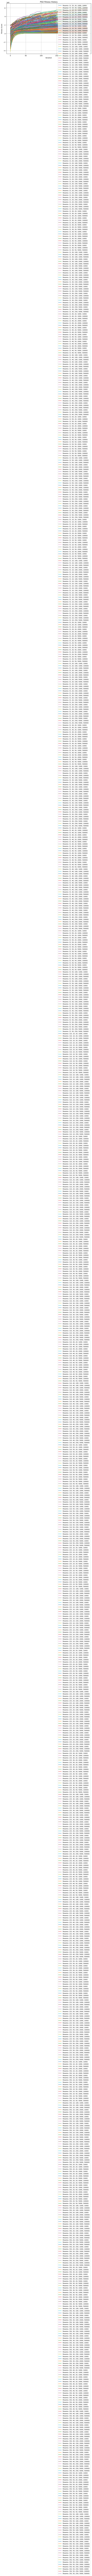

In [76]:
# Define parameter grid
param_grid = {
    "num_vehicles": [3, 5, 10,25,50],
    "swarm_size": [10, 20, 30,40,50],
    "num_iterations": [20, 50, 100,150,250],
    "coverage_factor": [1000, 2000, 5000],
    "overlap_penalty_factor": [1000, 10000, 50000]
}

# Load graph
G = load_road_network("Coimbatore, India")
start_nodes = get_police_station_nodes(G, place="Coimbatore, India")

# Run grid search
best_solution, best_fitness, best_params, fitness_history, df_results_sorted = grid_search(G, param_grid, start_nodes)

# Display the top 10 best parameter combinations
print(df_results_sorted)

# Plot fitness score history
plot_fitness_history(fitness_history)


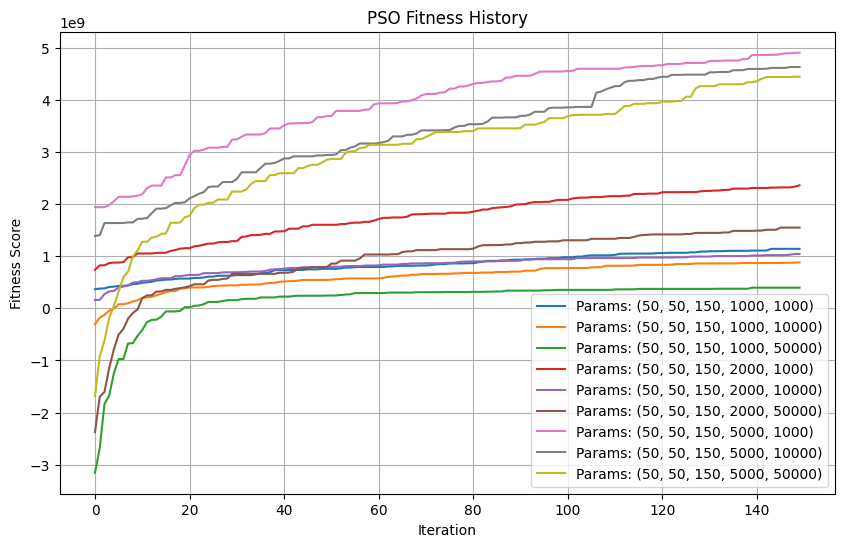

In [87]:
plot_fitness_history(fitness_history[-18:-9])


In [92]:
df_results_sorted

params       fitness  vehicle_intersections  \
1122   (50, 50, 250, 5000, 1000)  6.505764e+09                 112606   
1078  (50, 40, 250, 5000, 10000)  6.007405e+09                  73298   
1032   (50, 30, 250, 5000, 1000)  5.926300e+09                  68574   
1033  (50, 30, 250, 5000, 10000)  5.914877e+09                  55424   
897    (25, 50, 250, 5000, 1000)  5.900849e+09                  73541   
1077   (50, 40, 250, 5000, 1000)  5.795111e+09                  98579   
852    (25, 40, 250, 5000, 1000)  5.743302e+09                  54038   
1123  (50, 50, 250, 5000, 10000)  5.673327e+09                  95544   
987    (50, 20, 250, 5000, 1000)  5.480523e+09                  44483   
807    (25, 30, 250, 5000, 1000)  5.443270e+09                  40218   

                                                history  
1122  [1983962085.4902666, 2026862593.9045374, 20268...  
1078  [1131604715.9706347, 1228492253.2107608, 14102...  
1032  [1942314946.8170137, 1942314946.8170137, 20463...  
1033  [1235354109.7664027, 1247600488.399549, 132696...  
897   [1097815189.455528, 1362891648.1735046, 137563...  
1077  [2013972759.3911216, 2013972759.3911216, 20139...  
852   [1033615564.5492072, 1099839633.1392543, 11875...  
1123  [1253988646.679006, 1263110505.8811011, 139185...  
987   [1950456889.7305245, 1965610962.311266, 196561...  
807   [1086339720.1961224, 1086339720.1961224, 10863...

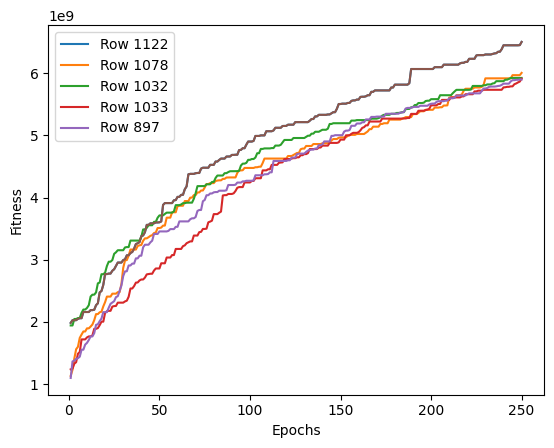

In [104]:
data = df_results_sorted['history'][1122]
var=0
for idx, row in df_results_sorted.iterrows():
    if var!=5:
        var+=1
    else:
        break
    history_data = row['history']
    plt.plot(range(1, len(history_data)+1), history_data, label=f"Row {idx}")
plt.legend()
plt.plot(range(1, len(data)+1), data)
plt.xlabel("Epochs")
plt.ylabel("Fitness")
plt.show()